In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# CNNモデルの定義
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()
print(model)

Using cpu device
CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
transform = T.Compose([
    # T.Resize(800),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 訓練データをdatasetsからダウンロード
training_data = datasets.CIFAR10(
    root="../data",
    train=True,
    download=True,
    transform=transform,
)

# テストデータをdatasetsからダウンロード
test_data = datasets.CIFAR10(
    root="../data",
    train=False,
    download=True,
    transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
batch_size = 4

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([4, 3, 32, 32])
Shape of y:  torch.Size([4]) torch.int64


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [58]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.282524  [    0/50000]
loss: 2.214510  [  400/50000]
loss: 2.209107  [  800/50000]
loss: 2.305845  [ 1200/50000]
loss: 2.254108  [ 1600/50000]
loss: 2.293937  [ 2000/50000]
loss: 2.308123  [ 2400/50000]
loss: 2.372203  [ 2800/50000]
loss: 2.261523  [ 3200/50000]
loss: 2.281411  [ 3600/50000]
loss: 2.337302  [ 4000/50000]
loss: 2.321142  [ 4400/50000]
loss: 2.359768  [ 4800/50000]
loss: 2.311946  [ 5200/50000]
loss: 2.271067  [ 5600/50000]
loss: 2.274000  [ 6000/50000]
loss: 2.307652  [ 6400/50000]
loss: 2.281654  [ 6800/50000]
loss: 2.293721  [ 7200/50000]
loss: 2.327312  [ 7600/50000]
loss: 2.292226  [ 8000/50000]
loss: 2.326719  [ 8400/50000]
loss: 2.312625  [ 8800/50000]
loss: 2.303690  [ 9200/50000]
loss: 2.272534  [ 9600/50000]
loss: 2.322595  [10000/50000]
loss: 2.315345  [10400/50000]
loss: 2.266666  [10800/50000]
loss: 2.297393  [11200/50000]
loss: 2.283367  [11600/50000]
loss: 2.269222  [12000/50000]
loss: 2.338009  [12400/50000]


In [59]:
# モデルの保存
PATH = './model/cnn_cifar.pth'
torch.save(model.state_dict(), PATH)

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   car   truck plane


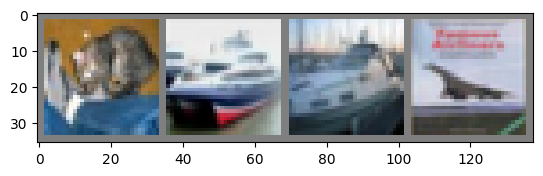

In [20]:
# テストデータでの評価
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

model = CNN()
# 保存した状態辞書をロード
model.load_state_dict(torch.load('../model/cnn_cifar.pth'))
model.eval()

# 画像の表示
def imshow(img):
    img = img / 2 + 0.5     # デノーマライズ
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off')  # 軸を非表示にする
    plt.show()

# 出力の表示
with torch.no_grad():
    outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

# 画像を表示
imshow(torchvision.utils.make_grid(images))